# Homework 1. Part 3

In [8]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import DataLoader

In [9]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

'cuda is available'

### Modifiable model

In [10]:
class ChangeableNetwork(nn.Module):
    def __init__(self, modification=512):
        super().__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(28*28, modification),
            nn.ReLU(),
            nn.Linear(modification, modification),
            nn.ReLU(),
            nn.Linear(modification, 10),
        )

    def forward(self, x):
        flat = nn.Flatten()
        x = flat(x)
        logits = self.linear_relu(x)
        return logits

### Utility Functions

In [11]:
def cnt_model_params(model):
    """Count model parameters"""
    count = 0
    with torch.no_grad():
        for param in model.parameters():
            count+=param.numel()
    return count

def display_model_info(model_name, model):
    """ Display model information"""
    count = 0
    for module in model.modules():
        if isinstance(module, nn.Module):
            count+=1
    display(model)
    display(f"{model_name}. parameters: {cnt_model_params(model)}")

In [12]:
# Randomly changed the lavels on the training dataset. Kept labels the same on test dataset.
training_ds = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=lambda label: torch.randint(0, 10, (1,)).item())
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())


### Training & eval loops

In [13]:
def nmist_train_loop(dataloader, model, loss_fn, optimize):
    """Training loop funciton for non-linear function"""
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        optimize.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()

        loss.backward()
        optimize.step()
    
    train_loss /= num_batches
    correct /=size
    return train_loss, correct
        
def nmist_val_loop(dataloader, model, loss_fn):
    """Eval loop function for non-linear function"""
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size
    return test_loss, correct

## Can network fit random labels?

In [14]:
# model
random_model = ChangeableNetwork(1024)

# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 500
lr = 1e-3
batch_size=64

random_label_df = pd.DataFrame()

# Dataloader
training_dl = DataLoader(training_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=64)

optimizer1 = torch.optim.SGD(random_model.parameters(), lr=lr)
display("Training & eval: Model with random labels")
for epoch in range(epochs):
    train_loss, train_correct = nmist_train_loop(training_dl, random_model, loss_fn, optimizer1)
    val_loss, val_correct = nmist_val_loop(test_dl, random_model, loss_fn)

    if random_label_df.empty:
        random_label_df = pd.DataFrame([[epoch, train_loss, val_loss]], columns=['epoch','train_loss','val_loss'])
    else:
        random_label_df = pd.concat([random_label_df, pd.DataFrame([[epoch, train_loss, val_loss]], columns=['epoch','train_loss','val_loss'])])

    
    if epoch%10 == 0:
        display(f'Epoch {epoch}. Training_loss: {train_loss}. Val_loss: {val_loss}. Training_correct:{train_correct}. Eval_correct:{val_correct}')
display("Done")



'Training & eval: Model with random labels'

'Epoch 0. Training_loss: 2.303004229500858. Val_loss: 2.301761929396611. Training_correct:0.0994. Eval_correct:0.1078'

'Epoch 10. Training_loss: 2.3028774955379427. Val_loss: 2.3009860500408585. Training_correct:0.10028333333333334. Eval_correct:0.1106'

'Epoch 20. Training_loss: 2.3026854780945443. Val_loss: 2.301092378652779. Training_correct:0.09831666666666666. Eval_correct:0.1317'

'Epoch 30. Training_loss: 2.3028459889548167. Val_loss: 2.3011404389788392. Training_correct:0.09736666666666667. Eval_correct:0.1139'

'Epoch 40. Training_loss: 2.3027767982564247. Val_loss: 2.3018232075272094. Training_correct:0.1008. Eval_correct:0.0999'

'Epoch 50. Training_loss: 2.3027051351726184. Val_loss: 2.3016752665209923. Training_correct:0.1022. Eval_correct:0.1035'

'Epoch 60. Training_loss: 2.3027056206518144. Val_loss: 2.3023818177022752. Training_correct:0.09993333333333333. Eval_correct:0.0924'

'Epoch 70. Training_loss: 2.302716553338301. Val_loss: 2.3015160484678425. Training_correct:0.10031666666666667. Eval_correct:0.1061'

'Epoch 80. Training_loss: 2.302682647572906. Val_loss: 2.301581376677106. Training_correct:0.10041666666666667. Eval_correct:0.1121'

'Epoch 90. Training_loss: 2.30272244720825. Val_loss: 2.301134513441924. Training_correct:0.09956666666666666. Eval_correct:0.1066'

'Epoch 100. Training_loss: 2.302712402109907. Val_loss: 2.301253520759048. Training_correct:0.0996. Eval_correct:0.1051'

'Epoch 110. Training_loss: 2.302763200517911. Val_loss: 2.3018867620237313. Training_correct:0.09691666666666666. Eval_correct:0.1069'

'Epoch 120. Training_loss: 2.302562261441115. Val_loss: 2.302020376654947. Training_correct:0.1007. Eval_correct:0.0927'

'Epoch 130. Training_loss: 2.3027337019377425. Val_loss: 2.3014780381682574. Training_correct:0.09836666666666667. Eval_correct:0.0997'

'Epoch 140. Training_loss: 2.3026153637147915. Val_loss: 2.301288338983135. Training_correct:0.09945. Eval_correct:0.1095'

'Epoch 150. Training_loss: 2.302704929797126. Val_loss: 2.3015587223563223. Training_correct:0.09756666666666666. Eval_correct:0.1183'

'Epoch 160. Training_loss: 2.3026409749029035. Val_loss: 2.3013493817323334. Training_correct:0.09831666666666666. Eval_correct:0.1178'

'Epoch 170. Training_loss: 2.302652016631576. Val_loss: 2.301945526888416. Training_correct:0.10256666666666667. Eval_correct:0.1059'

'Epoch 180. Training_loss: 2.3026271036693027. Val_loss: 2.301476284197182. Training_correct:0.10216666666666667. Eval_correct:0.1024'

'Epoch 190. Training_loss: 2.30267098717598. Val_loss: 2.301491324309331. Training_correct:0.10043333333333333. Eval_correct:0.1073'

'Epoch 200. Training_loss: 2.3026469928115163. Val_loss: 2.3018265544988545. Training_correct:0.10026666666666667. Eval_correct:0.1124'

'Epoch 210. Training_loss: 2.30274043433956. Val_loss: 2.3018626802286524. Training_correct:0.09893333333333333. Eval_correct:0.1138'

'Epoch 220. Training_loss: 2.3026288427523713. Val_loss: 2.301273601070331. Training_correct:0.10041666666666667. Eval_correct:0.1149'

'Epoch 230. Training_loss: 2.302712863950587. Val_loss: 2.301925700181609. Training_correct:0.09913333333333334. Eval_correct:0.1068'

'Epoch 240. Training_loss: 2.3026720076990026. Val_loss: 2.3023794881857125. Training_correct:0.0998. Eval_correct:0.1177'

'Epoch 250. Training_loss: 2.3026261357610416. Val_loss: 2.302297848804741. Training_correct:0.10185. Eval_correct:0.1037'

'Epoch 260. Training_loss: 2.3026505108835345. Val_loss: 2.3024392765798387. Training_correct:0.09993333333333333. Eval_correct:0.1018'

'Epoch 270. Training_loss: 2.3025766725479158. Val_loss: 2.3022565188681243. Training_correct:0.10255. Eval_correct:0.0975'

'Epoch 280. Training_loss: 2.30264523136082. Val_loss: 2.3026449984046304. Training_correct:0.09986666666666667. Eval_correct:0.1042'

'Epoch 290. Training_loss: 2.3027208265719383. Val_loss: 2.302309958038816. Training_correct:0.09876666666666667. Eval_correct:0.0925'

'Epoch 300. Training_loss: 2.3027167060990323. Val_loss: 2.3022381211542022. Training_correct:0.10005. Eval_correct:0.1062'

'Epoch 310. Training_loss: 2.302590336372603. Val_loss: 2.3021189012345236. Training_correct:0.09946666666666666. Eval_correct:0.1082'

'Epoch 320. Training_loss: 2.3025912089642686. Val_loss: 2.3025008189450404. Training_correct:0.09968333333333333. Eval_correct:0.1059'

'Epoch 330. Training_loss: 2.302653278114953. Val_loss: 2.302476444062154. Training_correct:0.10061666666666666. Eval_correct:0.0954'

'Epoch 340. Training_loss: 2.3026707634997012. Val_loss: 2.302173508200676. Training_correct:0.09963333333333334. Eval_correct:0.1018'

'Epoch 350. Training_loss: 2.3026207187282504. Val_loss: 2.302416265390481. Training_correct:0.10241666666666667. Eval_correct:0.109'

'Epoch 360. Training_loss: 2.3026937205654217. Val_loss: 2.3018792070400944. Training_correct:0.10038333333333334. Eval_correct:0.1064'

'Epoch 370. Training_loss: 2.3027084074549076. Val_loss: 2.302298925484821. Training_correct:0.0992. Eval_correct:0.108'

'Epoch 380. Training_loss: 2.3026363966561583. Val_loss: 2.302218668020455. Training_correct:0.10028333333333334. Eval_correct:0.0959'

'Epoch 390. Training_loss: 2.302642316960577. Val_loss: 2.303105960226363. Training_correct:0.09911666666666667. Eval_correct:0.0874'

'Epoch 400. Training_loss: 2.3026680651504092. Val_loss: 2.3024984803169395. Training_correct:0.09976666666666667. Eval_correct:0.1025'

'Epoch 410. Training_loss: 2.302673376445323. Val_loss: 2.3023979906823224. Training_correct:0.09943333333333333. Eval_correct:0.1032'

'Epoch 420. Training_loss: 2.3026767811541364. Val_loss: 2.302407645875481. Training_correct:0.1007. Eval_correct:0.1096'

'Epoch 430. Training_loss: 2.302660165819278. Val_loss: 2.3021190075358007. Training_correct:0.10101666666666667. Eval_correct:0.1005'

'Epoch 440. Training_loss: 2.302713012644477. Val_loss: 2.30179908017444. Training_correct:0.10046666666666666. Eval_correct:0.1199'

'Epoch 450. Training_loss: 2.3027309176764255. Val_loss: 2.301823359386177. Training_correct:0.0994. Eval_correct:0.1043'

'Epoch 460. Training_loss: 2.302624560876696. Val_loss: 2.302147944262073. Training_correct:0.10151666666666667. Eval_correct:0.1062'

'Epoch 470. Training_loss: 2.302662470193306. Val_loss: 2.3020887951942006. Training_correct:0.10033333333333333. Eval_correct:0.098'

'Epoch 480. Training_loss: 2.3026201038726613. Val_loss: 2.302072140821226. Training_correct:0.09973333333333333. Eval_correct:0.1158'

'Epoch 490. Training_loss: 2.302633883093974. Val_loss: 2.3019199629498135. Training_correct:0.10013333333333334. Eval_correct:0.1018'

'Done'

In [15]:
random_label_df

,epoch,train_loss,val_loss
0,0,2.303004,2.301762
0,1,2.302671,2.301660
0,2,2.302849,2.301251
0,3,2.302878,2.300979
0,4,2.302731,2.300934
...,...,...,...
0,495,2.302631,2.301863
0,496,2.302635,2.301970
0,497,2.302657,2.301793
0,498,2.302649,2.301736


<Axes: xlabel='epoch'>

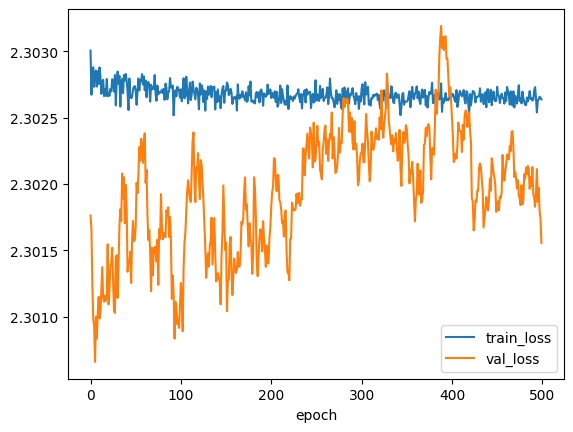

In [16]:
random_label_df.plot(x='epoch', y=['train_loss', 'val_loss'])